#  **1-Import of Main libraries & Seeds**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import os
import tensorflow as tf
import random
import warnings
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , classification_report
warnings.filterwarnings('ignore')
from tensorflow.keras.applications import VGG16 ,MobileNetV2 , ResNet152V2 , InceptionResNetV2 , Xception , DenseNet169
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

2025-12-10 13:06:50.192906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765372010.397780      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765372010.453656      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# **2-Preparing CSVs 🛠️**

In [2]:

root_folders = [
    
    "/kaggle/input/celebrities/test",
    "/kaggle/input/celebrities/train",
    "/kaggle/input/celebrities/val"
]

csv_files = ["test_dataset.csv", "train_dataset.csv", "val_dataset.csv"]

image_extensions = {".png", ".jpg", ".jpeg", ".bmp", ".gif", ".webp"}

for i, folder in enumerate(root_folders):

    data = []

    for celeb_name in os.listdir(folder):
        celeb_folder = os.path.join(folder, celeb_name)

        if os.path.isdir(celeb_folder):

            for img_file in os.listdir(celeb_folder):
                if any(img_file.lower().endswith(ext) for ext in image_extensions):

                    img_path = os.path.join(celeb_folder, img_file)

                    data.append({
                        "path": img_path,
                        "label": celeb_name
                    })

    df = pd.DataFrame(data)
    df.to_csv(csv_files[i], index=False)

    print(f"{csv_files[i]} Created Successfully!")


test_dataset.csv Created Successfully!
train_dataset.csv Created Successfully!
val_dataset.csv Created Successfully!


In [3]:
train_df = pd.read_csv(r'/kaggle/working/train_dataset.csv')
test_df = pd.read_csv(r'/kaggle/working/test_dataset.csv')
val_df = pd.read_csv(r'/kaggle/working/val_dataset.csv')

In [4]:
print(train_df.iloc[0][0])
print(val_df.iloc[0][0])
print(test_df.iloc[0][0])

/kaggle/input/celebrities/train/Amitab bachchan/Amitabh Bachchan_4.jpg
/kaggle/input/celebrities/val/Amitab bachchan/Amitabh Bachchan_71.jpg
/kaggle/input/celebrities/test/Amitab bachchan/Amitabh Bachchan_69.jpg


In [5]:
Total_Images = train_df.shape[0]
print(f"Total Images: {Total_Images}")
num_classes = train_df['label'].nunique()
print("Unique Classes:", num_classes)
classes = train_df['label'].unique()
print()
print("Classes:", classes)

Total Images: 981
Unique Classes: 17

Classes: ['Amitab bachchan' 'Billie Eilish' 'AkshayKumar' 'Alia Bhat'
 'charliz Theron' 'Henry Cavill' 'Brad pitt' 'Dwayne Johnson'
 'Elizabeth Olsen' 'camila cabello' 'Courtney Cox' 'Ellen Degeneres'
 'Hritik Roshan' 'Anushka shrama' 'claire Holt' 'Andy Samberg'
 'Alexgender']


# Select Required Labels

In [6]:
csvs = ["train_dataset.csv", "test_dataset.csv", "val_dataset.csv"]

allowed = [
    "Amitab bachchan",
    "Billie Eilish",
    "Alexgender",
    "Brad pitt",
    "camila cabello"
]

for file in csvs:
    df = pd.read_csv(file)
    df = df[df['label'].isin(allowed)]
    df.to_csv(file.replace(".csv", "_filtered.csv"), index=False)
    print(file, "Filtered!")


train_dataset.csv Filtered!
test_dataset.csv Filtered!
val_dataset.csv Filtered!


In [7]:
train_df = pd.read_csv(r'/kaggle/working/train_dataset_filtered.csv')
test_df = pd.read_csv(r'/kaggle/working/test_dataset_filtered.csv')
val_df = pd.read_csv(r'/kaggle/working/val_dataset_filtered.csv')

In [8]:
Total_Images = train_df.shape[0]
print(f"Total Images: {Total_Images}")
num_classes = train_df['label'].nunique()
print("Unique Classes:", num_classes)
classes = train_df['label'].unique()
print()
print("Classes:", classes)

Total Images: 318
Unique Classes: 5

Classes: ['Amitab bachchan' 'Billie Eilish' 'Brad pitt' 'camila cabello'
 'Alexgender']


# **3-Visualization For Data & Imbalanced labels 📊**

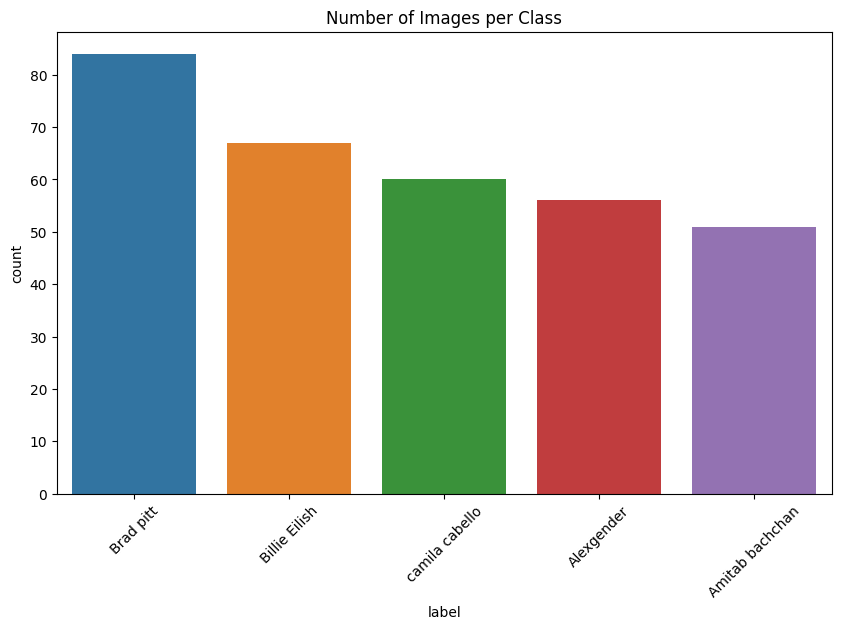

In [9]:
plt.figure(figsize=(10,6))
sns.countplot(data=train_df, x='label', order=train_df['label'].value_counts().index)
plt.title("Number of Images per Class")
plt.xticks(rotation=45)
plt.show()

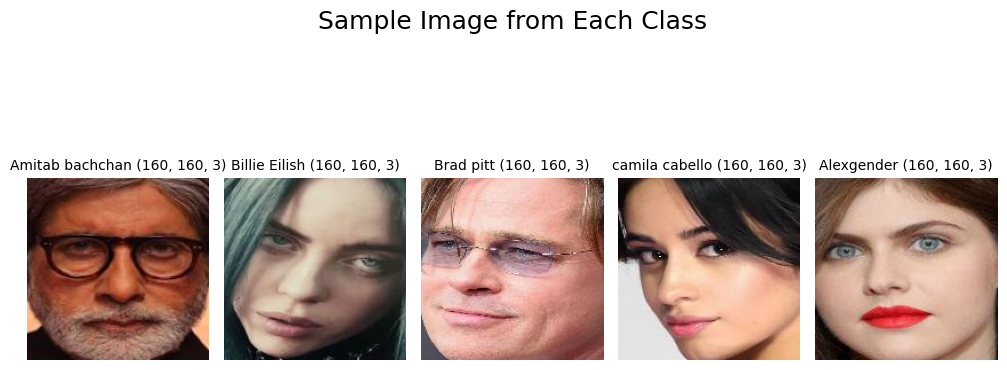

In [10]:
plt.figure(figsize=(10, 5))

num_classes = len(classes)
cols = 5
rows = (num_classes + cols - 1) // cols

for i, label in enumerate(classes):
    img_path = train_df[train_df['label'] == label]['path'].values[0]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"{label} {img.shape}", fontsize=10)
    plt.axis('off')

plt.suptitle("Sample Image from Each Class", fontsize=18)
plt.tight_layout()
plt.show()


# **4-Preparing Images 🛠️**

In [11]:
image_paths_train = train_df['path'].values
labels_train = train_df['label'].values

image_paths_val = val_df['path'].values
labels_val = val_df['label'].values

image_paths_test = test_df['path'].values
labels_test = test_df['label'].values


In [12]:
x_train = image_paths_train 
y_train = labels_train

x_val = image_paths_val
y_val = labels_val

x_test = image_paths_test
y_test = labels_test



x_full = np.concatenate((image_paths_train, image_paths_val), axis=0)
y_full = np.concatenate((labels_train, labels_val), axis=0)



# **Label Encoding For Labels**

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train = le.fit_transform(y_train)  
y_val   = le.transform(y_val)        
y_test  = le.transform(y_test)
y_full = le.transform(y_full)

# Scaling & Resizing  224 X 224

In [14]:
def preprocess_images(image_paths, img_size=(224, 224)):
    images = []
    for path in image_paths:
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)  
        image = tf.image.resize(image, img_size) / 255.0  
        images.append(image.numpy())
    return np.array(images)

x_train_images = preprocess_images(x_train)
x_val_images = preprocess_images(x_val)
x_test_images = preprocess_images(x_test)

x_full = np.concatenate((x_train_images, x_val_images), axis=0)


I0000 00:00:1765372025.679507      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [15]:
print(x_train_images.shape)
print(x_val_images.shape)
print(x_full.shape)


(318, 224, 224, 3)
(68, 224, 224, 3)
(386, 224, 224, 3)


# DataGenerator & Image Augmentation

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True
    
)



train_generator = train_datagen.flow(
    x_train_images,
    y_train,
    batch_size=8,
    shuffle=True   )

val_datagen = ImageDataGenerator()

val_generator = val_datagen.flow(
    x_val_images,
    y_val,
    batch_size=8,
    shuffle=False   )

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow(
    x_test_images,
    y_test,
    batch_size=8,
    shuffle=False   )

full_generator = train_datagen.flow(
    x_full,
    y_full,
    batch_size=8,
    shuffle=True   )

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)


class_weights_dict = dict(enumerate(class_weights))

# **5-Build CNN Model Architecture**

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras import regularizers


model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(num_classes, activation='softmax')
])

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau , ModelCheckpoint


early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)
checkpoint = ModelCheckpoint(
    'Best_Model_CNN_From_Scratch.h5',          
    monitor='val_loss',      
    save_best_only=True,      
    save_weights_only=False,  
    verbose=1
)





In [20]:
epochs = 50

history = model.fit(
   train_generator, 
    validation_data=val_generator,
    epochs=epochs,
    callbacks = [ early_stopping , reduce_lr , checkpoint ],
    class_weight=class_weights_dict)



Epoch 1/50


I0000 00:00:1765372031.830108      61 service.cc:148] XLA service 0x7ccef000bf60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765372031.830678      61 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765372032.101996      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


 4/40 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.1172 - loss: 1.6959

I0000 00:00:1765372035.948659      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.1451 - loss: 1.6492
Epoch 1: val_loss improved from inf to 1.59702, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 182ms/step - accuracy: 0.1456 - loss: 1.6487 - val_accuracy: 0.2059 - val_loss: 1.5970 - learning_rate: 1.0000e-04
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.2764 - loss: 1.5964
Epoch 2: val_loss improved from 1.59702 to 1.59049, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.2764 - loss: 1.5966 - val_accuracy: 0.2794 - val_loss: 1.5905 - learning_rate: 1.0000e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.2179 - loss: 1.6051
Epoch 3: val_loss improved from 1.59049 to 1.55362, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.2196 - loss: 1.6042 - val_accuracy: 0.3088 - val_loss: 1.5536 - learning_rate: 1.0000e-04
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3312 - loss: 1.5340
Epoch 4: val_loss improved from 1.55362 to 1.39167, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.3328 - loss: 1.5327 - val_accuracy: 0.4853 - val_loss: 1.3917 - learning_rate: 1.0000e-04
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3924 - loss: 1.5184
Epoch 5: val_loss improved from 1.39167 to 1.38910, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.3931 - loss: 1.5170 - val_accuracy: 0.4853 - val_loss: 1.3891 - learning_rate: 1.0000e-04
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.3819 - loss: 1.4090
Epoch 6: val_loss improved from 1.38910 to 1.28692, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.3824 - loss: 1.4089 - val_accuracy: 0.6618 - val_loss: 1.2869 - learning_rate: 1.0000e-04
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4493 - loss: 1.3525
Epoch 7: val_loss did not improve from 1.28692
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.4486 - loss: 1.3532 - val_accuracy: 0.6176 - val_loss: 1.3117 - learning_rate: 1.0000e-04
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4001 - loss: 1.3964
Epoch 8: val_loss improved from 1.28692 to 1.21582, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.4006 - loss: 1.3960 - val_accuracy: 0.7353 - val_loss: 1.2158 - learning_rate: 1.0000e-04
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5412 - loss: 1.2519
Epoch 9: val_loss improved from 1.21582 to 1.09832, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.5409 - loss: 1.2522 - val_accuracy: 0.6765 - val_loss: 1.0983 - learning_rate: 1.0000e-04
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5053 - loss: 1.2306
Epoch 10: val_loss improved from 1.09832 to 1.07214, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.5051 - loss: 1.2312 - val_accuracy: 0.7647 - val_loss: 1.0721 - learning_rate: 1.0000e-04
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5451 - loss: 1.1899
Epoch 11: val_loss improved from 1.07214 to 1.07071, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.5440 - loss: 1.1914 - val_accuracy: 0.6618 - val_loss: 1.0707 - learning_rate: 1.0000e-04
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4758 - loss: 1.2675
Epoch 12: val_loss improved from 1.07071 to 1.04757, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.4773 - loss: 1.2664 - val_accuracy: 0.7206 - val_loss: 1.0476 - learning_rate: 1.0000e-04
Epoch 13/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5275 - loss: 1.1858
Epoch 13: val_loss improved from 1.04757 to 0.99097, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.5276 - loss: 1.1854 - val_accuracy: 0.7647 - val_loss: 0.9910 - learning_rate: 1.0000e-04
Epoch 14/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5218 - loss: 1.1490
Epoch 14: val_loss improved from 0.99097 to 0.95833, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.5226 - loss: 1.1479 - val_accuracy: 0.7794 - val_loss: 0.9583 - learning_rate: 5.0000e-05
Epoch 15/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5617 - loss: 1.0827
Epoch 15: val_loss improved from 0.95833 to 0.91064, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5622 - loss: 1.0821 - val_accuracy: 0.7794 - val_loss: 0.9106 - learning_rate: 5.0000e-05
Epoch 16/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5427 - loss: 1.1583
Epoch 16: val_loss improved from 0.91064 to 0.90192, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.5429 - loss: 1.1578 - val_accuracy: 0.7500 - val_loss: 0.9019 - learning_rate: 5.0000e-05
Epoch 17/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5280 - loss: 1.1038
Epoch 17: val_loss improved from 0.90192 to 0.88110, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5287 - loss: 1.1039 - val_accuracy: 0.7794 - val_loss: 0.8811 - learning_rate: 5.0000e-05
Epoch 18/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5750 - loss: 1.0667
Epoch 18: val_loss did not improve from 0.88110
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.5749 - loss: 1.0669 - val_accuracy: 0.7647 - val_loss: 0.8874 - learning_rate: 2.5000e-05
Epoch 19/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5730 - loss: 1.0549
Epoch 19: val_loss improved from 0.88110 to 0.87627, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5734 - loss: 1.0547 - val_accuracy: 0.7647 - val_loss: 0.8763 - learning_rate: 2.5000e-05
Epoch 20/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5903 - loss: 1.0893
Epoch 20: val_loss did not improve from 0.87627
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.5905 - loss: 1.0895 - val_accuracy: 0.7647 - val_loss: 0.8807 - learning_rate: 2.5000e-05
Epoch 21/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6173 - loss: 0.9976
Epoch 21: val_loss improved from 0.87627 to 0.86604, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.6174 - loss: 0.9986 - val_accuracy: 0.7647 - val_loss: 0.8660 - learning_rate: 1.2500e-05
Epoch 22/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5951 - loss: 1.0712
Epoch 22: val_loss improved from 0.86604 to 0.86114, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5953 - loss: 1.0711 - val_accuracy: 0.7941 - val_loss: 0.8611 - learning_rate: 1.2500e-05
Epoch 23/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6274 - loss: 0.9937
Epoch 23: val_loss improved from 0.86114 to 0.85725, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.6273 - loss: 0.9942 - val_accuracy: 0.7794 - val_loss: 0.8572 - learning_rate: 1.2500e-05
Epoch 24/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5810 - loss: 1.0373
Epoch 24: val_loss improved from 0.85725 to 0.84805, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.5811 - loss: 1.0367 - val_accuracy: 0.8088 - val_loss: 0.8480 - learning_rate: 1.2500e-05
Epoch 25/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5916 - loss: 1.0494
Epoch 25: val_loss improved from 0.84805 to 0.84499, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.5912 - loss: 1.0505 - val_accuracy: 0.7941 - val_loss: 0.8450 - learning_rate: 1.2500e-05
Epoch 26/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6273 - loss: 1.0470
Epoch 26: val_loss improved from 0.84499 to 0.84306, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.6268 - loss: 1.0478 - val_accuracy: 0.7941 - val_loss: 0.8431 - learning_rate: 1.2500e-05
Epoch 27/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5785 - loss: 1.0430
Epoch 27: val_loss improved from 0.84306 to 0.84211, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.5785 - loss: 1.0430 - val_accuracy: 0.7941 - val_loss: 0.8421 - learning_rate: 1.2500e-05
Epoch 28/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6236 - loss: 1.0007
Epoch 28: val_loss improved from 0.84211 to 0.83688, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.6235 - loss: 1.0008 - val_accuracy: 0.8235 - val_loss: 0.8369 - learning_rate: 6.2500e-06
Epoch 29/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5656 - loss: 1.0626
Epoch 29: val_loss improved from 0.83688 to 0.83187, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5659 - loss: 1.0617 - val_accuracy: 0.8088 - val_loss: 0.8319 - learning_rate: 6.2500e-06
Epoch 30/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6243 - loss: 0.9676
Epoch 30: val_loss improved from 0.83187 to 0.83020, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.6243 - loss: 0.9685 - val_accuracy: 0.8088 - val_loss: 0.8302 - learning_rate: 6.2500e-06
Epoch 31/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6679 - loss: 0.9546
Epoch 31: val_loss improved from 0.83020 to 0.82937, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.6671 - loss: 0.9554 - val_accuracy: 0.7941 - val_loss: 0.8294 - learning_rate: 6.2500e-06
Epoch 32/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5312 - loss: 1.0461
Epoch 32: val_loss improved from 0.82937 to 0.82810, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.5328 - loss: 1.0447 - val_accuracy: 0.8088 - val_loss: 0.8281 - learning_rate: 3.1250e-06
Epoch 33/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5944 - loss: 1.0212
Epoch 33: val_loss improved from 0.82810 to 0.82743, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.5946 - loss: 1.0210 - val_accuracy: 0.8088 - val_loss: 0.8274 - learning_rate: 3.1250e-06
Epoch 34/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6247 - loss: 0.9726
Epoch 34: val_loss improved from 0.82743 to 0.82535, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.6247 - loss: 0.9723 - val_accuracy: 0.8088 - val_loss: 0.8254 - learning_rate: 3.1250e-06
Epoch 35/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6196 - loss: 0.9888
Epoch 35: val_loss improved from 0.82535 to 0.82412, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.6197 - loss: 0.9889 - val_accuracy: 0.8088 - val_loss: 0.8241 - learning_rate: 1.5625e-06
Epoch 36/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6143 - loss: 1.0411
Epoch 36: val_loss improved from 0.82412 to 0.82297, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.6147 - loss: 1.0399 - val_accuracy: 0.8235 - val_loss: 0.8230 - learning_rate: 1.5625e-06
Epoch 37/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6493 - loss: 1.0148
Epoch 37: val_loss improved from 0.82297 to 0.82289, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.6490 - loss: 1.0148 - val_accuracy: 0.8235 - val_loss: 0.8229 - learning_rate: 1.5625e-06
Epoch 38/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6658 - loss: 0.9106
Epoch 38: val_loss improved from 0.82289 to 0.82171, saving model to Best_Model_CNN_From_Scratch.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.6643 - loss: 0.9118 - val_accuracy: 0.8235 - val_loss: 0.8217 - learning_rate: 1.0000e-06


In [21]:
history_full = model.fit(
   full_generator, 
    validation_data=val_generator,
    epochs=epochs,
    callbacks = [ early_stopping , reduce_lr , checkpoint ],
    class_weight=class_weights_dict
)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.5787 - loss: 0.9787
Epoch 1: val_loss did not improve from 0.82171
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.5787 - loss: 0.9792 - val_accuracy: 0.8088 - val_loss: 0.8353 - learning_rate: 1.0000e-06
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6206 - loss: 0.9663
Epoch 2: val_loss did not improve from 0.82171
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.6201 - loss: 0.9673 - val_accuracy: 0.8235 - val_loss: 0.8346 - learning_rate: 1.0000e-06
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5946 - loss: 1.0332
Epoch 3: val_loss did not improve from 0.82171
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.5946 - loss: 1.0332 - val_accuracy: 0.8088 - val_loss: 0.8327 - learning_rate: 1.0000e-06
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6532 - loss: 0.9688
Epoch 4: val_loss did not improve from 0.82171
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/ste

# **Evaluate CNN Model**

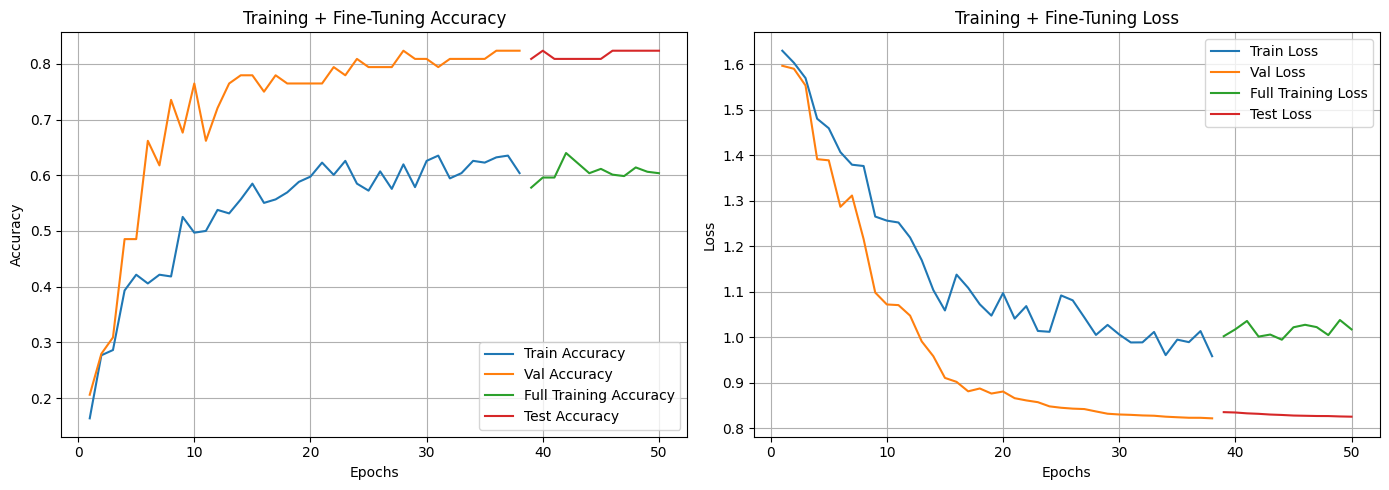

In [22]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
full_acc = history_full.history['accuracy']
test_acc = history_full.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']
full_loss = history_full.history['loss']
test_loss = history_full.history['val_loss']

epochs_train_val = range(1, len(train_acc)+1)
epochs_full = range(len(train_acc)+1, len(train_acc)+len(full_acc)+1)

plt.figure(figsize=(14,5))

# --------- Subplot 1: Accuracy ---------
plt.subplot(1,2,1)
plt.plot(epochs_train_val, train_acc, label='Train Accuracy')
plt.plot(epochs_train_val, val_acc, label='Val Accuracy')
plt.plot(epochs_full, full_acc, label='Full Training Accuracy')
plt.plot(epochs_full, test_acc, label='Test Accuracy')
plt.title('Training + Fine-Tuning Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# --------- Subplot 2: Loss ---------
plt.subplot(1,2,2)
plt.plot(epochs_train_val, train_loss, label='Train Loss')
plt.plot(epochs_train_val, val_loss, label='Val Loss')
plt.plot(epochs_full, full_loss, label='Full Training Loss')
plt.plot(epochs_full, test_loss, label='Test Loss')
plt.title('Training + Fine-Tuning Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# **Confusion Matrix Of CNN**

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step


<Figure size 1500x2000 with 0 Axes>

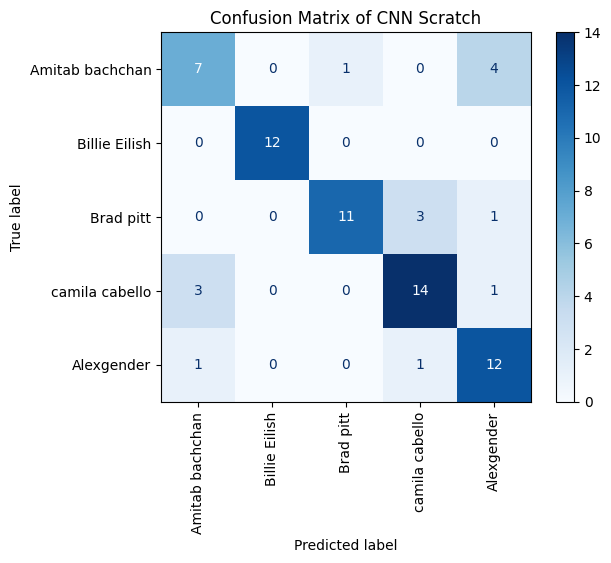

Classification Report:

                 precision    recall  f1-score   support

     Alexgender       0.64      0.58      0.61        12
Amitab bachchan       1.00      1.00      1.00        12
  Billie Eilish       0.92      0.73      0.81        15
      Brad pitt       0.78      0.78      0.78        18
 camila cabello       0.67      0.86      0.75        14

       accuracy                           0.79        71
      macro avg       0.80      0.79      0.79        71
   weighted avg       0.80      0.79      0.79        71



In [23]:
y_pred = model.predict(x_test_images)
predicted_labels = np.argmax(y_pred, axis=1)

predicted_label_names = le.inverse_transform(predicted_labels)
true_label_names = le.inverse_transform(y_test)


cm = confusion_matrix(y_test, predicted_labels)


plt.figure(figsize=(15, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix of CNN Scratch")
plt.show()

report = classification_report(true_label_names, predicted_label_names, target_names=le.classes_)
print("Classification Report:\n")
print(report)

# **6-Build **VGG16** Transfer Learning Model**

In [24]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False  

x = base_model.output
x = Flatten()(x)
output = Dense(num_classes, activation='softmax')(x)


model_pretrained = Model(inputs=base_model.input, outputs=output)



model_pretrained.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │       125,445 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,840,133 (56.61 MB)

 Trainable params: 125,445 (490.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [25]:
# Compile the model
model_pretrained.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau , ModelCheckpoint
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)
checkpoint = ModelCheckpoint(
    'Best_Model_VGG16.h5',          
    monitor='val_loss',      
    save_best_only=True,      
    save_weights_only=False,  
    verbose=1
)

In [27]:
epochs = 50

history_pretrained = model_pretrained.fit(
   train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks = [early_stopping,reduce_lr , checkpoint],
    class_weight=class_weights_dict
)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.3332 - loss: 2.4352
Epoch 1: val_loss improved from inf to 1.20255, saving model to Best_Model_VGG16.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 221ms/step - accuracy: 0.3336 - loss: 2.4232 - val_accuracy: 0.6029 - val_loss: 1.2026 - learning_rate: 0.0010
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5307 - loss: 1.1402
Epoch 2: val_loss improved from 1.20255 to 0.84288, saving model to Best_Model_VGG16.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.5311 - loss: 1.1394 - val_accuracy: 0.6471 - val_loss: 0.8429 - learning_rate: 0.0010
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6450 - loss: 0.9017
Epoch 3: val_loss improved from 0.84288 to 0.46371, saving model to Best_Model_VGG16.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.6451 - loss: 0.9010 - val_accuracy: 0.7941 - val_loss: 0.4637 - learning_rate: 0.0010
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7451 - loss: 0.7317
Epoch 4: val_loss improved from 0.46371 to 0.43139, saving model to Best_Model_VGG16.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.7455 - loss: 0.7296 - val_accuracy: 0.7794 - val_loss: 0.4314 - learning_rate: 0.0010
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7697 - loss: 0.6772
Epoch 5: val_loss did not improve from 0.43139
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.7695 - loss: 0.6766 - val_accuracy: 0.8529 - val_loss: 0.5934 - learning_rate: 0.0010
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8356 - loss: 0.5389
Epoch 6: val_loss improved from 0.43139 to 0.31953, saving model to Best_Model_VGG16.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.8345 - loss: 0.5406 - val_accuracy: 0.8824 - val_loss: 0.3195 - learning_rate: 0.0010
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7702 - loss: 0.6427
Epoch 7: val_loss did not improve from 0.31953
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.7698 - loss: 0.6438 - val_accuracy: 0.8088 - val_loss: 0.5415 - learning_rate: 0.0010
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7754 - loss: 0.5456
Epoch 8: val_loss did not improve from 0.31953
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.7752 - loss: 0.5465 - val_accuracy: 0.8382 - val_loss: 0.4633 - learning_rate: 0.0010
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6921 - loss: 0.8415
Epoch 9: val_loss did not improve from 0.31953
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.6933 - loss: 0.8386 - val_accuracy: 0.8088 - val_loss: 0.5324 - learning_rate: 0.0010
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 77

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.7969 - loss: 0.5522 - val_accuracy: 0.8971 - val_loss: 0.2518 - learning_rate: 5.0000e-04
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8183 - loss: 0.4700
Epoch 11: val_loss improved from 0.25182 to 0.19633, saving model to Best_Model_VGG16.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.8185 - loss: 0.4700 - val_accuracy: 0.9265 - val_loss: 0.1963 - learning_rate: 5.0000e-04
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8333 - loss: 0.4972
Epoch 12: val_loss improved from 0.19633 to 0.19511, saving model to Best_Model_VGG16.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.8342 - loss: 0.4946 - val_accuracy: 0.9265 - val_loss: 0.1951 - learning_rate: 5.0000e-04
Epoch 13/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8524 - loss: 0.4221
Epoch 13: val_loss did not improve from 0.19511
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.8512 - loss: 0.4245 - val_accuracy: 0.8382 - val_loss: 0.4099 - learning_rate: 5.0000e-04
Epoch 14/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7665 - loss: 0.5618
Epoch 14: val_loss did not improve from 0.19511
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.7674 - loss: 0.5601 - val_accuracy: 0.8971 - val_loss: 0.2248 - learning_rate: 5.0000e-04
Epoch 15/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8915 - loss: 0.3482
Epoch 15: val_loss did not improve from 0.19511
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.8910 - loss: 0.3489 - val_accuracy: 0.9118 - val_loss: 0.2103 - learning_rate: 2.5000e-04
Epoch 16/50
40/40 ━━━━

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.8500 - loss: 0.3574 - val_accuracy: 0.9265 - val_loss: 0.1942 - learning_rate: 2.5000e-04
Epoch 18/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9174 - loss: 0.2526
Epoch 18: val_loss did not improve from 0.19415
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.9172 - loss: 0.2529 - val_accuracy: 0.8971 - val_loss: 0.2116 - learning_rate: 1.2500e-04
Epoch 19/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8594 - loss: 0.3217
Epoch 19: val_loss did not improve from 0.19415
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.8594 - loss: 0.3214 - val_accuracy: 0.8824 - val_loss: 0.2774 - learning_rate: 1.2500e-04
Epoch 20/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8661 - loss: 0.3683
Epoch 20: val_loss did not improve from 0.19415
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.8663 - loss: 0.3671 - val_accuracy: 0.8971 - val_loss: 0.2180 - learning_rate: 1.2500e-04
Epoch 21/50
40/40 ━━━━

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.8983 - loss: 0.3013 - val_accuracy: 0.9118 - val_loss: 0.1933 - learning_rate: 6.2500e-05
Epoch 23/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8952 - loss: 0.2998
Epoch 23: val_loss did not improve from 0.19328
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.8949 - loss: 0.3001 - val_accuracy: 0.8824 - val_loss: 0.2863 - learning_rate: 6.2500e-05
Epoch 24/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9127 - loss: 0.3033
Epoch 24: val_loss did not improve from 0.19328
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9126 - loss: 0.3036 - val_accuracy: 0.9118 - val_loss: 0.2137 - learning_rate: 3.1250e-05
Epoch 25/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8793 - loss: 0.3174
Epoch 25: val_loss did not improve from 0.19328
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.8793 - loss: 0.3176 - val_accuracy: 0.9118 - val_loss: 0.2031 - learning_rate: 3.1250e-05
Epoch 26/50
40/40 ━━━━

In [28]:

history_pretrained_full = model_pretrained.fit(
   full_generator, 
    validation_data=val_generator,
    epochs=epochs,
    callbacks = [ early_stopping , reduce_lr , checkpoint ],
    class_weight=class_weights_dict
)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8922 - loss: 0.3536
Epoch 1: val_loss improved from 0.19328 to 0.18509, saving model to Best_Model_VGG16.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.8920 - loss: 0.3537 - val_accuracy: 0.9265 - val_loss: 0.1851 - learning_rate: 1.5625e-05
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8968 - loss: 0.3226
Epoch 2: val_loss improved from 0.18509 to 0.18221, saving model to Best_Model_VGG16.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.8963 - loss: 0.3233 - val_accuracy: 0.9265 - val_loss: 0.1822 - learning_rate: 1.5625e-05
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9111 - loss: 0.3203
Epoch 3: val_loss improved from 0.18221 to 0.16089, saving model to Best_Model_VGG16.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9108 - loss: 0.3205 - val_accuracy: 0.9706 - val_loss: 0.1609 - learning_rate: 1.5625e-05
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9015 - loss: 0.3145
Epoch 4: val_loss did not improve from 0.16089
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9012 - loss: 0.3148 - val_accuracy: 0.9265 - val_loss: 0.1669 - learning_rate: 1.5625e-05
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9024 - loss: 0.3136
Epoch 5: val_loss did not improve from 0.16089
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9022 - loss: 0.3139 - val_accuracy: 0.9265 - val_loss: 0.1780 - learning_rate: 1.5625e-05
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8864 - loss: 0.3384
Epoch 6: val_loss did not improve from 0.16089
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.8863 - loss: 0.3387 - val_accuracy: 0.9265 - val_loss: 0.1700 - learning_rate: 1.5625e-05
Epoch 7/50
49/49 ━━━━━━━━━━━

# **VGG16 Evaluate**

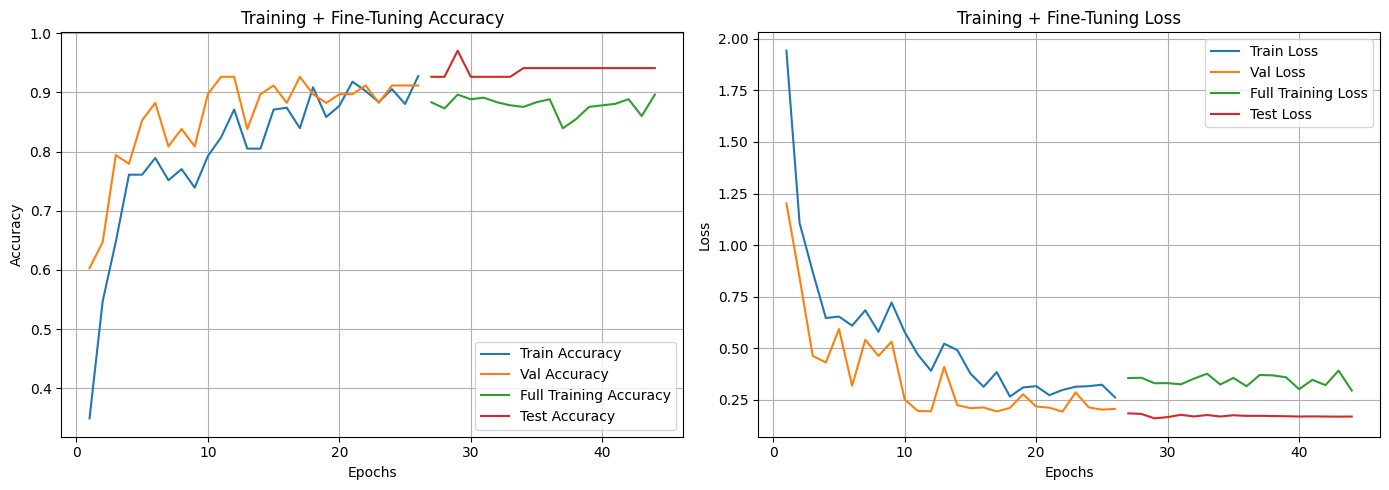

In [29]:
train_acc = history_pretrained.history['accuracy']
val_acc = history_pretrained.history['val_accuracy']
full_acc = history_pretrained_full.history['accuracy']
test_acc = history_pretrained_full.history['val_accuracy']

train_loss = history_pretrained.history['loss']
val_loss = history_pretrained.history['val_loss']
full_loss = history_pretrained_full.history['loss']
test_loss = history_pretrained_full.history['val_loss']


epochs_train_val = range(1, len(train_acc)+1)
epochs_full = range(len(train_acc)+1, len(train_acc)+len(full_acc)+1)

plt.figure(figsize=(14,5))


plt.subplot(1,2,1)
plt.plot(epochs_train_val, train_acc, label='Train Accuracy')
plt.plot(epochs_train_val, val_acc, label='Val Accuracy')
plt.plot(epochs_full, full_acc, label='Full Training Accuracy')
plt.plot(epochs_full, test_acc, label='Test Accuracy')
plt.title('Training + Fine-Tuning Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.subplot(1,2,2)
plt.plot(epochs_train_val, train_loss, label='Train Loss')
plt.plot(epochs_train_val, val_loss, label='Val Loss')
plt.plot(epochs_full, full_loss, label='Full Training Loss')
plt.plot(epochs_full, test_loss, label='Test Loss')
plt.title('Training + Fine-Tuning Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# **VGG16 Confusion Matrix**

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


<Figure size 1000x800 with 0 Axes>

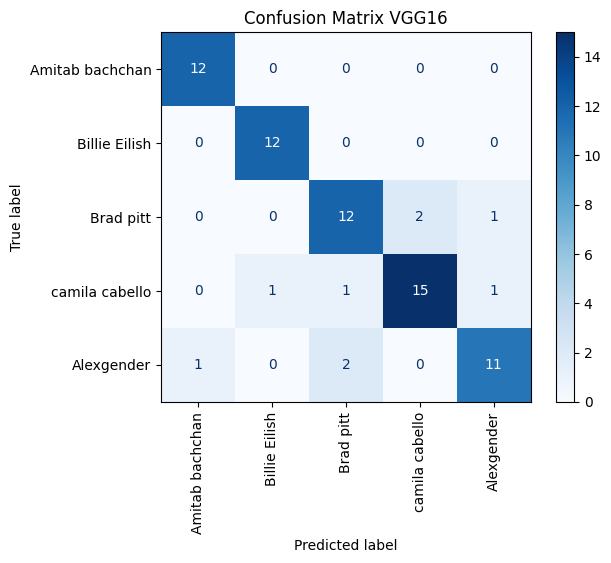

Classification Report:

                 precision    recall  f1-score   support

     Alexgender       0.92      1.00      0.96        12
Amitab bachchan       0.92      1.00      0.96        12
  Billie Eilish       0.80      0.80      0.80        15
      Brad pitt       0.88      0.83      0.86        18
 camila cabello       0.85      0.79      0.81        14

       accuracy                           0.87        71
      macro avg       0.87      0.88      0.88        71
   weighted avg       0.87      0.87      0.87        71



In [30]:
y_pred = model_pretrained.predict(x_test_images)
predicted_labels = np.argmax(y_pred, axis=1)

predicted_label_names = le.inverse_transform(predicted_labels)
true_label_names = le.inverse_transform(y_test)


cm = confusion_matrix(y_test, predicted_labels)


plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix VGG16")
plt.show()

report = classification_report(true_label_names, predicted_label_names, target_names=le.classes_)
print("Classification Report:\n")
print(report)

# **7-Build DenseNet169 Transfer Learning**

In [31]:
base_model = DenseNet169(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224,3)
)
base_model.trainable = False  

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(num_classes, activation='softmax')(x)


model_pretrained_DenseNet169 = Model(inputs=base_model.input, outputs=output)



model_pretrained_DenseNet169.summary()

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 12,651,205 (48.26 MB)

 Trainable params: 8,325 (32.52 KB)

 Non-trainable params: 12,642,880 (48.23 MB)

In [32]:
model_pretrained_DenseNet169.compile(optimizer=Adam(learning_rate=1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau , ModelCheckpoint
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)
checkpoint = ModelCheckpoint(
    'Best_Model_DenseNet169.h5',          
    monitor='val_loss',      
    save_best_only=True,      
    save_weights_only=False,  
    verbose=1
)

In [34]:

epochs = 50

history_DenseNet169 = model_pretrained_DenseNet169.fit(
   train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks = [early_stopping,reduce_lr , checkpoint],
    class_weight=class_weights_dict)





Epoch 1/50
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.2760 - loss: 1.5628
Epoch 1: val_loss improved from inf to 1.27617, saving model to Best_Model_DenseNet169.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.2810 - loss: 1.5565 - val_accuracy: 0.4118 - val_loss: 1.2762 - learning_rate: 0.0010
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5921 - loss: 1.0555
Epoch 2: val_loss improved from 1.27617 to 1.11670, saving model to Best_Model_DenseNet169.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.5925 - loss: 1.0550 - val_accuracy: 0.5147 - val_loss: 1.1167 - learning_rate: 0.0010
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6683 - loss: 0.8906
Epoch 3: val_loss improved from 1.11670 to 1.03221, saving model to Best_Model_DenseNet169.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.6694 - loss: 0.8898 - val_accuracy: 0.5441 - val_loss: 1.0322 - learning_rate: 0.0010
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7610 - loss: 0.7528
Epoch 4: val_loss improved from 1.03221 to 0.72200, saving model to Best_Model_DenseNet169.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.7613 - loss: 0.7520 - val_accuracy: 0.7500 - val_loss: 0.7220 - learning_rate: 0.0010
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8505 - loss: 0.5984
Epoch 5: val_loss improved from 0.72200 to 0.65164, saving model to Best_Model_DenseNet169.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.8500 - loss: 0.5988 - val_accuracy: 0.7941 - val_loss: 0.6516 - learning_rate: 0.0010
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8174 - loss: 0.5927
Epoch 6: val_loss improved from 0.65164 to 0.54951, saving model to Best_Model_DenseNet169.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.8177 - loss: 0.5919 - val_accuracy: 0.8382 - val_loss: 0.5495 - learning_rate: 0.0010
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8350 - loss: 0.5112
Epoch 7: val_loss improved from 0.54951 to 0.53990, saving model to Best_Model_DenseNet169.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.8353 - loss: 0.5110 - val_accuracy: 0.8824 - val_loss: 0.5399 - learning_rate: 0.0010
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9063 - loss: 0.4454
Epoch 8: val_loss improved from 0.53990 to 0.52234, saving model to Best_Model_DenseNet169.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9056 - loss: 0.4462 - val_accuracy: 0.8088 - val_loss: 0.5223 - learning_rate: 0.0010
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8590 - loss: 0.4494
Epoch 9: val_loss improved from 0.52234 to 0.45278, saving model to Best_Model_DenseNet169.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.8590 - loss: 0.4492 - val_accuracy: 0.8971 - val_loss: 0.4528 - learning_rate: 0.0010
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8882 - loss: 0.4215
Epoch 10: val_loss improved from 0.45278 to 0.40053, saving model to Best_Model_DenseNet169.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.8880 - loss: 0.4217 - val_accuracy: 0.9118 - val_loss: 0.4005 - learning_rate: 0.0010
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8500 - loss: 0.3754
Epoch 11: val_loss improved from 0.40053 to 0.38937, saving model to Best_Model_DenseNet169.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.8510 - loss: 0.3749 - val_accuracy: 0.9559 - val_loss: 0.3894 - learning_rate: 0.0010
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9460 - loss: 0.3447
Epoch 12: val_loss improved from 0.38937 to 0.37397, saving model to Best_Model_DenseNet169.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9454 - loss: 0.3450 - val_accuracy: 0.9265 - val_loss: 0.3740 - learning_rate: 0.0010
Epoch 13/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9218 - loss: 0.3116
Epoch 13: val_loss improved from 0.37397 to 0.34522, saving model to Best_Model_DenseNet169.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9214 - loss: 0.3124 - val_accuracy: 0.9559 - val_loss: 0.3452 - learning_rate: 0.0010
Epoch 14/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9032 - loss: 0.3002
Epoch 14: val_loss did not improve from 0.34522
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.9033 - loss: 0.3003 - val_accuracy: 0.9118 - val_loss: 0.3536 - learning_rate: 0.0010
Epoch 15/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9217 - loss: 0.3290
Epoch 15: val_loss improved from 0.34522 to 0.32910, saving model to Best_Model_DenseNet169.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9218 - loss: 0.3286 - val_accuracy: 0.9265 - val_loss: 0.3291 - learning_rate: 5.0000e-04
Epoch 16/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9064 - loss: 0.2979
Epoch 16: val_loss did not improve from 0.32910
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9063 - loss: 0.2983 - val_accuracy: 0.9412 - val_loss: 0.3318 - learning_rate: 5.0000e-04
Epoch 17/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9275 - loss: 0.3012
Epoch 17: val_loss improved from 0.32910 to 0.30407, saving model to Best_Model_DenseNet169.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9273 - loss: 0.3017 - val_accuracy: 0.9118 - val_loss: 0.3041 - learning_rate: 5.0000e-04
Epoch 18/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9326 - loss: 0.2656
Epoch 18: val_loss improved from 0.30407 to 0.29925, saving model to Best_Model_DenseNet169.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.9322 - loss: 0.2667 - val_accuracy: 0.9412 - val_loss: 0.2992 - learning_rate: 2.5000e-04
Epoch 19/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9126 - loss: 0.2829
Epoch 19: val_loss improved from 0.29925 to 0.29357, saving model to Best_Model_DenseNet169.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9121 - loss: 0.2838 - val_accuracy: 0.9706 - val_loss: 0.2936 - learning_rate: 2.5000e-04
Epoch 20/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9065 - loss: 0.2834
Epoch 20: val_loss improved from 0.29357 to 0.29336, saving model to Best_Model_DenseNet169.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9067 - loss: 0.2832 - val_accuracy: 0.9559 - val_loss: 0.2934 - learning_rate: 2.5000e-04
Epoch 21/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9664 - loss: 0.2671
Epoch 21: val_loss did not improve from 0.29336
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.9657 - loss: 0.2670 - val_accuracy: 0.9706 - val_loss: 0.2953 - learning_rate: 2.5000e-04
Epoch 22/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9280 - loss: 0.3018
Epoch 22: val_loss improved from 0.29336 to 0.28483, saving model to Best_Model_DenseNet169.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9279 - loss: 0.3018 - val_accuracy: 0.9706 - val_loss: 0.2848 - learning_rate: 2.5000e-04
Epoch 23/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9240 - loss: 0.3124
Epoch 23: val_loss did not improve from 0.28483
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.9241 - loss: 0.3119 - val_accuracy: 0.9559 - val_loss: 0.2857 - learning_rate: 1.2500e-04
Epoch 24/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9137 - loss: 0.2620
Epoch 24: val_loss improved from 0.28483 to 0.28363, saving model to Best_Model_DenseNet169.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9143 - loss: 0.2620 - val_accuracy: 0.9559 - val_loss: 0.2836 - learning_rate: 1.2500e-04
Epoch 25/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9295 - loss: 0.2793
Epoch 25: val_loss improved from 0.28363 to 0.27799, saving model to Best_Model_DenseNet169.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9295 - loss: 0.2792 - val_accuracy: 0.9706 - val_loss: 0.2780 - learning_rate: 1.2500e-04
Epoch 26/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9208 - loss: 0.2998
Epoch 26: val_loss improved from 0.27799 to 0.27661, saving model to Best_Model_DenseNet169.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9209 - loss: 0.2995 - val_accuracy: 0.9706 - val_loss: 0.2766 - learning_rate: 6.2500e-05
Epoch 27/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9215 - loss: 0.2791
Epoch 27: val_loss improved from 0.27661 to 0.27562, saving model to Best_Model_DenseNet169.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9218 - loss: 0.2788 - val_accuracy: 0.9706 - val_loss: 0.2756 - learning_rate: 6.2500e-05
Epoch 28/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9162 - loss: 0.2952
Epoch 28: val_loss improved from 0.27562 to 0.27510, saving model to Best_Model_DenseNet169.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9167 - loss: 0.2948 - val_accuracy: 0.9706 - val_loss: 0.2751 - learning_rate: 6.2500e-05
Epoch 29/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9177 - loss: 0.3087
Epoch 29: val_loss did not improve from 0.27510
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.9177 - loss: 0.3084 - val_accuracy: 0.9706 - val_loss: 0.2759 - learning_rate: 3.1250e-05


In [35]:
history_DenseNet169_full = model_pretrained_DenseNet169.fit(
   full_generator, 
    validation_data=val_generator,
    epochs=epochs,
    callbacks = [ early_stopping , reduce_lr , checkpoint ],
    class_weight=class_weights_dict
)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9245 - loss: 0.3137
Epoch 1: val_loss did not improve from 0.27510
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step - accuracy: 0.9246 - loss: 0.3132 - val_accuracy: 0.9706 - val_loss: 0.2934 - learning_rate: 3.1250e-05
Epoch 2/50
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9087 - loss: 0.2817
Epoch 2: val_loss did not improve from 0.27510
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.9095 - loss: 0.2811 - val_accuracy: 0.9706 - val_loss: 0.2925 - learning_rate: 3.1250e-05
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9299 - loss: 0.2683
Epoch 3: val_loss did not improve from 0.27510
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.9301 - loss: 0.2684 - val_accuracy: 0.9706 - val_loss: 0.2906 - learning_rate: 3.1250e-05
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9477 - loss: 0.2582
Epoch 4: val_loss did not improve from 0.27510
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/st

# **Evaluate DenseNet169**

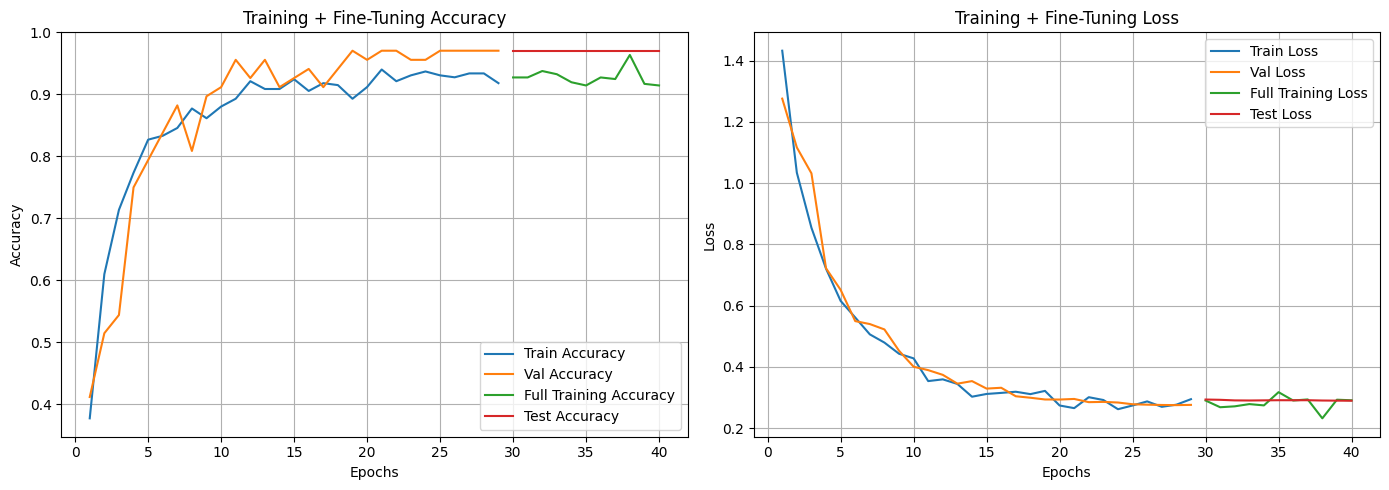

In [36]:
train_acc = history_DenseNet169.history['accuracy']
val_acc = history_DenseNet169.history['val_accuracy']
full_acc = history_DenseNet169_full.history['accuracy']
test_acc = history_DenseNet169_full.history['val_accuracy']

train_loss = history_DenseNet169.history['loss']
val_loss = history_DenseNet169.history['val_loss']
full_loss = history_DenseNet169_full.history['loss']
test_loss = history_DenseNet169_full.history['val_loss']


epochs_train_val = range(1, len(train_acc)+1)
epochs_full = range(len(train_acc)+1, len(train_acc)+len(full_acc)+1)

plt.figure(figsize=(14,5))


plt.subplot(1,2,1)
plt.plot(epochs_train_val, train_acc, label='Train Accuracy')
plt.plot(epochs_train_val, val_acc, label='Val Accuracy')
plt.plot(epochs_full, full_acc, label='Full Training Accuracy')
plt.plot(epochs_full, test_acc, label='Test Accuracy')
plt.title('Training + Fine-Tuning Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.subplot(1,2,2)
plt.plot(epochs_train_val, train_loss, label='Train Loss')
plt.plot(epochs_train_val, val_loss, label='Val Loss')
plt.plot(epochs_full, full_loss, label='Full Training Loss')
plt.plot(epochs_full, test_loss, label='Test Loss')
plt.title('Training + Fine-Tuning Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# **DenseNet169 Confusion Matrix**

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7ccea37393a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 9s/step


<Figure size 1000x800 with 0 Axes>

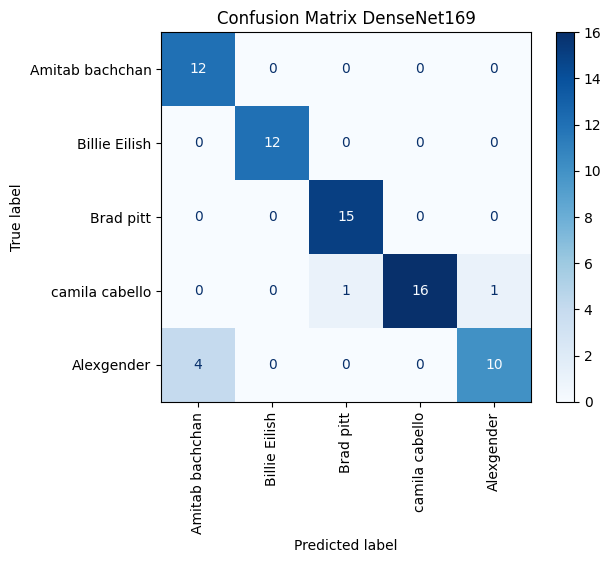

Classification Report:

                 precision    recall  f1-score   support

     Alexgender       0.75      1.00      0.86        12
Amitab bachchan       1.00      1.00      1.00        12
  Billie Eilish       0.94      1.00      0.97        15
      Brad pitt       1.00      0.89      0.94        18
 camila cabello       0.91      0.71      0.80        14

       accuracy                           0.92        71
      macro avg       0.92      0.92      0.91        71
   weighted avg       0.93      0.92      0.91        71



In [37]:
y_pred = model_pretrained_DenseNet169.predict(x_test_images)
predicted_labels = np.argmax(y_pred, axis=1)

predicted_label_names = le.inverse_transform(predicted_labels)
true_label_names = le.inverse_transform(y_test)


cm = confusion_matrix(y_test, predicted_labels)


plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix DenseNet169")
plt.show()

report = classification_report(true_label_names, predicted_label_names, target_names=le.classes_)
print("Classification Report:\n")
print(report)

# **8-Build ResNet152V2 Transfer Learning Model**

In [38]:
from tensorflow.keras.regularizers import l2

base_model = ResNet152V2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False  

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(
    num_classes,
    activation='softmax',
    kernel_regularizer=l2(0.001)
)(x)

model_pretrained_ResNet152V2 = Model(inputs=base_model.input, outputs=output)

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [39]:
model_pretrained_ResNet152V2.compile(optimizer=Adam(learning_rate=1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [40]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau , ModelCheckpoint
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)
checkpoint = ModelCheckpoint(
    'Best_Model_ResNet152V2.h5',          
    monitor='val_loss',      
    save_best_only=True,      
    save_weights_only=False,  
    verbose=1
)

In [41]:

epochs = 50

history_ResNet152V2 = model_pretrained_ResNet152V2.fit(
   train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks = [early_stopping,reduce_lr , checkpoint],
    class_weight=class_weights_dict)



Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.2901 - loss: 1.9491
Epoch 1: val_loss improved from inf to 0.94855, saving model to Best_Model_ResNet152V2.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 47s 620ms/step - accuracy: 0.2917 - loss: 1.9440 - val_accuracy: 0.6324 - val_loss: 0.9486 - learning_rate: 0.0010
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4507 - loss: 1.3510
Epoch 2: val_loss improved from 0.94855 to 0.74638, saving model to Best_Model_ResNet152V2.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.4522 - loss: 1.3485 - val_accuracy: 0.7206 - val_loss: 0.7464 - learning_rate: 0.0010
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6503 - loss: 0.9452
Epoch 3: val_loss improved from 0.74638 to 0.58620, saving model to Best_Model_ResNet152V2.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.6498 - loss: 0.9453 - val_accuracy: 0.8824 - val_loss: 0.5862 - learning_rate: 0.0010
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6965 - loss: 0.8747
Epoch 4: val_loss improved from 0.58620 to 0.58259, saving model to Best_Model_ResNet152V2.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.6964 - loss: 0.8742 - val_accuracy: 0.7500 - val_loss: 0.5826 - learning_rate: 0.0010
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6979 - loss: 0.7656
Epoch 5: val_loss improved from 0.58259 to 0.49816, saving model to Best_Model_ResNet152V2.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.6983 - loss: 0.7653 - val_accuracy: 0.8235 - val_loss: 0.4982 - learning_rate: 0.0010
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7520 - loss: 0.6712
Epoch 6: val_loss improved from 0.49816 to 0.48303, saving model to Best_Model_ResNet152V2.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.7520 - loss: 0.6710 - val_accuracy: 0.8529 - val_loss: 0.4830 - learning_rate: 0.0010
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7933 - loss: 0.6188
Epoch 7: val_loss improved from 0.48303 to 0.45462, saving model to Best_Model_ResNet152V2.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.7922 - loss: 0.6203 - val_accuracy: 0.8824 - val_loss: 0.4546 - learning_rate: 5.0000e-04
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7638 - loss: 0.5698
Epoch 8: val_loss improved from 0.45462 to 0.45074, saving model to Best_Model_ResNet152V2.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.7643 - loss: 0.5694 - val_accuracy: 0.8382 - val_loss: 0.4507 - learning_rate: 5.0000e-04
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7426 - loss: 0.6051
Epoch 9: val_loss improved from 0.45074 to 0.41123, saving model to Best_Model_ResNet152V2.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.7434 - loss: 0.6042 - val_accuracy: 0.9412 - val_loss: 0.4112 - learning_rate: 5.0000e-04
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7585 - loss: 0.6642
Epoch 10: val_loss improved from 0.41123 to 0.39695, saving model to Best_Model_ResNet152V2.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.7584 - loss: 0.6645 - val_accuracy: 0.9118 - val_loss: 0.3969 - learning_rate: 5.0000e-04
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8061 - loss: 0.5731
Epoch 11: val_loss improved from 0.39695 to 0.38754, saving model to Best_Model_ResNet152V2.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.8061 - loss: 0.5730 - val_accuracy: 0.9412 - val_loss: 0.3875 - learning_rate: 5.0000e-04
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8045 - loss: 0.5087
Epoch 12: val_loss improved from 0.38754 to 0.37647, saving model to Best_Model_ResNet152V2.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.8047 - loss: 0.5089 - val_accuracy: 0.9412 - val_loss: 0.3765 - learning_rate: 5.0000e-04
Epoch 13/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8012 - loss: 0.5802
Epoch 13: val_loss improved from 0.37647 to 0.36743, saving model to Best_Model_ResNet152V2.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.8016 - loss: 0.5788 - val_accuracy: 0.9412 - val_loss: 0.3674 - learning_rate: 2.5000e-04
Epoch 14/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8042 - loss: 0.4817
Epoch 14: val_loss did not improve from 0.36743
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.8037 - loss: 0.4828 - val_accuracy: 0.8971 - val_loss: 0.3766 - learning_rate: 2.5000e-04
Epoch 15/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7885 - loss: 0.6015
Epoch 15: val_loss improved from 0.36743 to 0.36102, saving model to Best_Model_ResNet152V2.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.7888 - loss: 0.6003 - val_accuracy: 0.9412 - val_loss: 0.3610 - learning_rate: 2.5000e-04
Epoch 16/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8628 - loss: 0.4447
Epoch 16: val_loss improved from 0.36102 to 0.35960, saving model to Best_Model_ResNet152V2.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.8620 - loss: 0.4464 - val_accuracy: 0.9412 - val_loss: 0.3596 - learning_rate: 1.2500e-04
Epoch 17/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8220 - loss: 0.5318
Epoch 17: val_loss did not improve from 0.35960
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.8216 - loss: 0.5319 - val_accuracy: 0.9265 - val_loss: 0.3614 - learning_rate: 1.2500e-04
Epoch 18/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8402 - loss: 0.4230
Epoch 18: val_loss did not improve from 0.35960
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.8397 - loss: 0.4245 - val_accuracy: 0.9118 - val_loss: 0.3618 - learning_rate: 1.2500e-04
Epoch 19/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8242 - loss: 0.5003
Epoch 19: val_loss did not improve from 0.35960
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.8243 - loss: 0.4998 - val_accuracy: 0.8971 - val_loss: 0.3610 - learning_rate: 6.2500e-05


In [42]:
for layer in base_model.layers[-40:]:
    layer.trainable = True

history_ResNet152V2_Full = model_pretrained_ResNet152V2.fit(
   full_generator, 
    validation_data=val_generator,
    epochs=epochs,
    callbacks = [ early_stopping , reduce_lr , checkpoint ],
    class_weight=class_weights_dict
)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7861 - loss: 0.5836
Epoch 1: val_loss did not improve from 0.35960
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.7860 - loss: 0.5836 - val_accuracy: 0.9559 - val_loss: 0.4057 - learning_rate: 6.2500e-05
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7960 - loss: 0.6231
Epoch 2: val_loss did not improve from 0.35960
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.7959 - loss: 0.6222 - val_accuracy: 0.9412 - val_loss: 0.4046 - learning_rate: 6.2500e-05
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7604 - loss: 0.6185
Epoch 3: val_loss did not improve from 0.35960
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.7605 - loss: 0.6185 - val_accuracy: 0.9412 - val_loss: 0.3995 - learning_rate: 6.2500e-05
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8247 - loss: 0.5412
Epoch 4: val_loss did not improve from 0.35960
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/ste

# **Evaluate ResNet152V2**

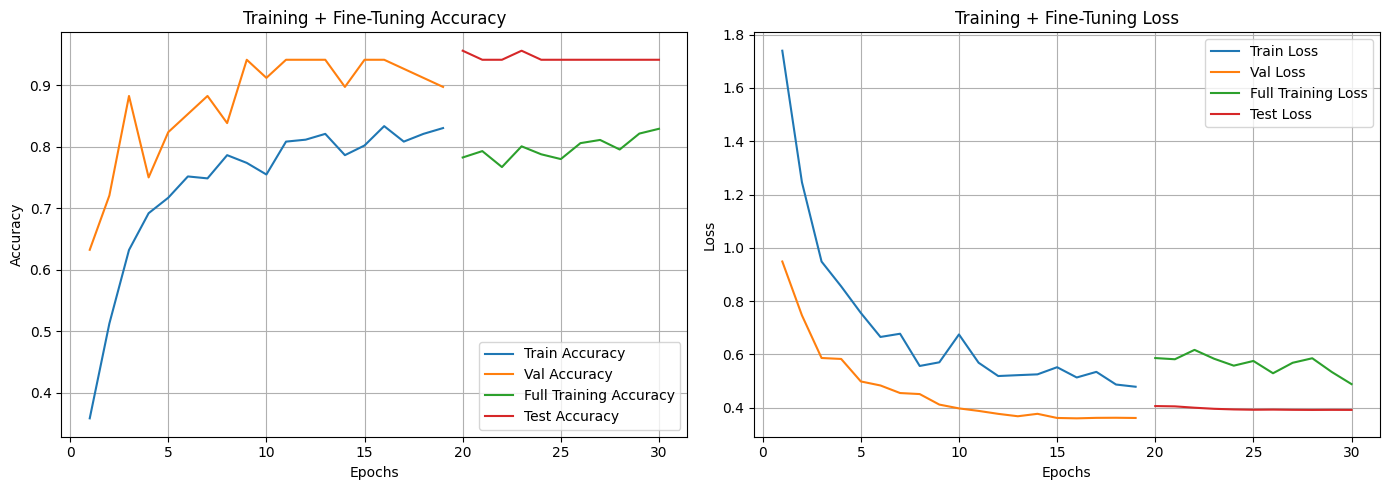

In [43]:
import matplotlib.pyplot as plt


train_acc = history_ResNet152V2.history['accuracy']
val_acc = history_ResNet152V2.history['val_accuracy']
full_acc = history_ResNet152V2_Full.history['accuracy']
test_acc = history_ResNet152V2_Full.history['val_accuracy']

train_loss = history_ResNet152V2.history['loss']
val_loss = history_ResNet152V2.history['val_loss']
full_loss = history_ResNet152V2_Full.history['loss']
test_loss = history_ResNet152V2_Full.history['val_loss']


epochs_train_val = range(1, len(train_acc)+1)
epochs_full = range(len(train_acc)+1, len(train_acc)+len(full_acc)+1)

plt.figure(figsize=(14,5))


plt.subplot(1,2,1)
plt.plot(epochs_train_val, train_acc, label='Train Accuracy')
plt.plot(epochs_train_val, val_acc, label='Val Accuracy')
plt.plot(epochs_full, full_acc, label='Full Training Accuracy')
plt.plot(epochs_full, test_acc, label='Test Accuracy')
plt.title('Training + Fine-Tuning Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.subplot(1,2,2)
plt.plot(epochs_train_val, train_loss, label='Train Loss')
plt.plot(epochs_train_val, val_loss, label='Val Loss')
plt.plot(epochs_full, full_loss, label='Full Training Loss')
plt.plot(epochs_full, test_loss, label='Test Loss')
plt.title('Training + Fine-Tuning Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# **ResNet152V2 Confusion Matrix**

3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step


<Figure size 1000x800 with 0 Axes>

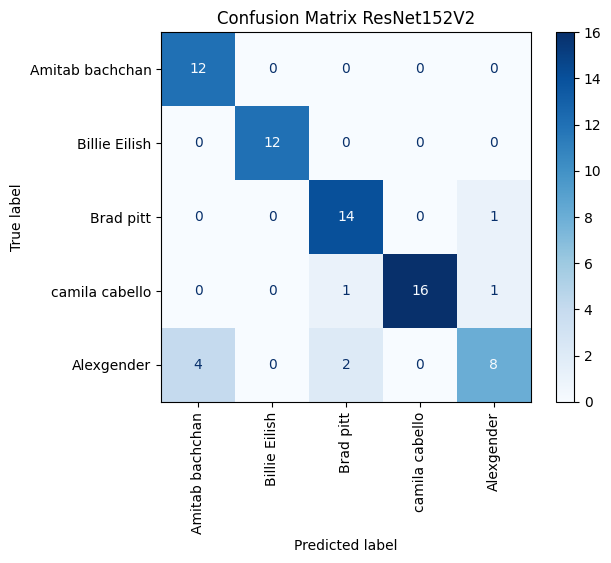

Classification Report:

                 precision    recall  f1-score   support

     Alexgender       0.75      1.00      0.86        12
Amitab bachchan       1.00      1.00      1.00        12
  Billie Eilish       0.82      0.93      0.87        15
      Brad pitt       1.00      0.89      0.94        18
 camila cabello       0.80      0.57      0.67        14

       accuracy                           0.87        71
      macro avg       0.87      0.88      0.87        71
   weighted avg       0.88      0.87      0.87        71



In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


y_pred = model_pretrained_ResNet152V2.predict(x_test_images)
predicted_labels = np.argmax(y_pred, axis=1)

predicted_label_names = le.inverse_transform(predicted_labels)
true_label_names = le.inverse_transform(y_test)


cm = confusion_matrix(y_test, predicted_labels)


plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix ResNet152V2")
plt.show()


report = classification_report(true_label_names, predicted_label_names, target_names=le.classes_)
print("Classification Report:\n")
print(report)

# **9-Build Xception Transfer Learning Model**

In [45]:
from tensorflow.keras.regularizers import l2

base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False  

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(
    num_classes,
    activation='softmax',
    kernel_regularizer=l2(0.001)
)(x)

model_pretrained_Xception = Model(inputs=base_model.input, outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [46]:
model_pretrained_Xception.compile(optimizer=Adam(learning_rate=1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [47]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)
checkpoint = ModelCheckpoint(
    'Best_Model_Xception.h5',          
    monitor='val_loss',      
    save_best_only=True,      
    save_weights_only=False,  
    verbose=1
)

In [48]:
epochs = 50

history_Xception = model_pretrained_Xception.fit(
   train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks = [early_stopping,reduce_lr , checkpoint],
    class_weight=class_weights_dict)



Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.2780 - loss: 1.6195
Epoch 1: val_loss improved from inf to 1.17974, saving model to Best_Model_Xception.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 292ms/step - accuracy: 0.2799 - loss: 1.6163 - val_accuracy: 0.5441 - val_loss: 1.1797 - learning_rate: 0.0010
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4978 - loss: 1.2248
Epoch 2: val_loss improved from 1.17974 to 1.03685, saving model to Best_Model_Xception.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.4992 - loss: 1.2228 - val_accuracy: 0.6324 - val_loss: 1.0369 - learning_rate: 0.0010
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6298 - loss: 1.0313
Epoch 3: val_loss improved from 1.03685 to 0.91621, saving model to Best_Model_Xception.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.6301 - loss: 1.0296 - val_accuracy: 0.6912 - val_loss: 0.9162 - learning_rate: 0.0010
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7150 - loss: 0.8216
Epoch 4: val_loss improved from 0.91621 to 0.83863, saving model to Best_Model_Xception.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.7158 - loss: 0.8207 - val_accuracy: 0.6912 - val_loss: 0.8386 - learning_rate: 0.0010
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6854 - loss: 0.7829
Epoch 5: val_loss did not improve from 0.83863
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.6854 - loss: 0.7835 - val_accuracy: 0.6765 - val_loss: 0.8626 - learning_rate: 0.0010
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6930 - loss: 0.7557
Epoch 6: val_loss improved from 0.83863 to 0.81630, saving model to Best_Model_Xception.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.6943 - loss: 0.7555 - val_accuracy: 0.7059 - val_loss: 0.8163 - learning_rate: 0.0010
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7582 - loss: 0.6588
Epoch 7: val_loss improved from 0.81630 to 0.80213, saving model to Best_Model_Xception.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.7585 - loss: 0.6590 - val_accuracy: 0.6912 - val_loss: 0.8021 - learning_rate: 0.0010
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7961 - loss: 0.6487
Epoch 8: val_loss improved from 0.80213 to 0.78769, saving model to Best_Model_Xception.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.7957 - loss: 0.6485 - val_accuracy: 0.7059 - val_loss: 0.7877 - learning_rate: 0.0010
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8170 - loss: 0.6018
Epoch 9: val_loss improved from 0.78769 to 0.71806, saving model to Best_Model_Xception.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.8168 - loss: 0.6025 - val_accuracy: 0.7647 - val_loss: 0.7181 - learning_rate: 0.0010
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8106 - loss: 0.6185
Epoch 10: val_loss improved from 0.71806 to 0.68165, saving model to Best_Model_Xception.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.8107 - loss: 0.6178 - val_accuracy: 0.7500 - val_loss: 0.6817 - learning_rate: 0.0010
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8201 - loss: 0.5283
Epoch 11: val_loss did not improve from 0.68165
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.8205 - loss: 0.5280 - val_accuracy: 0.7500 - val_loss: 0.6910 - learning_rate: 0.0010
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7874 - loss: 0.5405
Epoch 12: val_loss improved from 0.68165 to 0.64315, saving model to Best_Model_Xception.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.7872 - loss: 0.5413 - val_accuracy: 0.7941 - val_loss: 0.6432 - learning_rate: 0.0010
Epoch 13/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8647 - loss: 0.5029
Epoch 13: val_loss did not improve from 0.64315
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.8643 - loss: 0.5039 - val_accuracy: 0.7794 - val_loss: 0.6466 - learning_rate: 0.0010
Epoch 14/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8326 - loss: 0.6038
Epoch 14: val_loss did not improve from 0.64315
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.8322 - loss: 0.6033 - val_accuracy: 0.8382 - val_loss: 0.6477 - learning_rate: 0.0010
Epoch 15/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8357 - loss: 0.4897
Epoch 15: val_loss improved from 0.64315 to 0.63247, saving model to Best_Model_Xception.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.8351 - loss: 0.4905 - val_accuracy: 0.7647 - val_loss: 0.6325 - learning_rate: 0.0010
Epoch 16/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7932 - loss: 0.6295
Epoch 16: val_loss improved from 0.63247 to 0.61430, saving model to Best_Model_Xception.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.7935 - loss: 0.6284 - val_accuracy: 0.8235 - val_loss: 0.6143 - learning_rate: 0.0010
Epoch 17/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8300 - loss: 0.5472
Epoch 17: val_loss did not improve from 0.61430
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.8300 - loss: 0.5468 - val_accuracy: 0.8088 - val_loss: 0.6336 - learning_rate: 0.0010
Epoch 18/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7846 - loss: 0.5951
Epoch 18: val_loss did not improve from 0.61430
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.7850 - loss: 0.5944 - val_accuracy: 0.7794 - val_loss: 0.6434 - learning_rate: 5.0000e-04
Epoch 19/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7729 - loss: 0.6188
Epoch 19: val_loss did not improve from 0.61430
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.7735 - loss: 0.6178 - val_accuracy: 0.7941 - val_loss: 0.6312 - learning_rate: 5.0000e-04
Epoch 20/50
40/40 ━━━━━━━━━━━━

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.8548 - loss: 0.4888 - val_accuracy: 0.8088 - val_loss: 0.6048 - learning_rate: 2.5000e-04
Epoch 24/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8325 - loss: 0.4905
Epoch 24: val_loss did not improve from 0.60477
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.8330 - loss: 0.4905 - val_accuracy: 0.8088 - val_loss: 0.6101 - learning_rate: 1.2500e-04


In [49]:
model_pretrained_Xception.compile(optimizer=Adam(learning_rate=1e-5),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


for layer in base_model.layers[-40:]:
    layer.trainable = True



history_Xception_Full = model_pretrained_Xception.fit(
   full_generator, 
    validation_data=val_generator,
    epochs=epochs,
    callbacks = [ early_stopping , reduce_lr , checkpoint ],
    class_weight=class_weights_dict
)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.3939 - loss: 1.4402
Epoch 1: val_loss did not improve from 0.60477
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 311ms/step - accuracy: 0.3950 - loss: 1.4400 - val_accuracy: 0.6912 - val_loss: 0.7165 - learning_rate: 1.0000e-05
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4965 - loss: 1.2873
Epoch 2: val_loss did not improve from 0.60477
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.4962 - loss: 1.2884 - val_accuracy: 0.6912 - val_loss: 0.7507 - learning_rate: 1.0000e-05
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5599 - loss: 1.1800
Epoch 3: val_loss did not improve from 0.60477
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.5600 - loss: 1.1794 - val_accuracy: 0.6765 - val_loss: 0.7327 - learning_rate: 1.0000e-05
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6127 - loss: 1.0777
Epoch 4: val_loss did not improve from 0.60477
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/st

49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.7480 - loss: 0.7587 - val_accuracy: 0.8676 - val_loss: 0.5927 - learning_rate: 5.0000e-06
Epoch 13/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7371 - loss: 0.7455
Epoch 13: val_loss improved from 0.59271 to 0.57614, saving model to Best_Model_Xception.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.7372 - loss: 0.7454 - val_accuracy: 0.8676 - val_loss: 0.5761 - learning_rate: 5.0000e-06
Epoch 14/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7759 - loss: 0.6495
Epoch 14: val_loss improved from 0.57614 to 0.53867, saving model to Best_Model_Xception.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.7760 - loss: 0.6495 - val_accuracy: 0.8676 - val_loss: 0.5387 - learning_rate: 5.0000e-06
Epoch 15/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8344 - loss: 0.5577
Epoch 15: val_loss improved from 0.53867 to 0.51620, saving model to Best_Model_Xception.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.8344 - loss: 0.5588 - val_accuracy: 0.8824 - val_loss: 0.5162 - learning_rate: 2.5000e-06
Epoch 16/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7403 - loss: 0.7075
Epoch 16: val_loss improved from 0.51620 to 0.49348, saving model to Best_Model_Xception.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.7409 - loss: 0.7065 - val_accuracy: 0.8824 - val_loss: 0.4935 - learning_rate: 2.5000e-06
Epoch 17/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8024 - loss: 0.6036
Epoch 17: val_loss improved from 0.49348 to 0.48707, saving model to Best_Model_Xception.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.8023 - loss: 0.6037 - val_accuracy: 0.8824 - val_loss: 0.4871 - learning_rate: 2.5000e-06
Epoch 18/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8260 - loss: 0.6175
Epoch 18: val_loss improved from 0.48707 to 0.48005, saving model to Best_Model_Xception.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.8256 - loss: 0.6180 - val_accuracy: 0.8824 - val_loss: 0.4801 - learning_rate: 2.5000e-06
Epoch 19/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7921 - loss: 0.6308
Epoch 19: val_loss improved from 0.48005 to 0.47738, saving model to Best_Model_Xception.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.7922 - loss: 0.6305 - val_accuracy: 0.8971 - val_loss: 0.4774 - learning_rate: 1.2500e-06
Epoch 20/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8392 - loss: 0.5460
Epoch 20: val_loss improved from 0.47738 to 0.46585, saving model to Best_Model_Xception.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.8387 - loss: 0.5470 - val_accuracy: 0.8971 - val_loss: 0.4659 - learning_rate: 1.2500e-06
Epoch 21/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8056 - loss: 0.6212
Epoch 21: val_loss improved from 0.46585 to 0.45423, saving model to Best_Model_Xception.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.8061 - loss: 0.6203 - val_accuracy: 0.8971 - val_loss: 0.4542 - learning_rate: 1.2500e-06
Epoch 22/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8276 - loss: 0.5710
Epoch 22: val_loss improved from 0.45423 to 0.44678, saving model to Best_Model_Xception.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.8271 - loss: 0.5715 - val_accuracy: 0.8971 - val_loss: 0.4468 - learning_rate: 1.2500e-06
Epoch 23/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8044 - loss: 0.6408
Epoch 23: val_loss improved from 0.44678 to 0.44547, saving model to Best_Model_Xception.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.8047 - loss: 0.6397 - val_accuracy: 0.9118 - val_loss: 0.4455 - learning_rate: 1.0000e-06
Epoch 24/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8487 - loss: 0.5618
Epoch 24: val_loss improved from 0.44547 to 0.44279, saving model to Best_Model_Xception.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.8484 - loss: 0.5619 - val_accuracy: 0.9118 - val_loss: 0.4428 - learning_rate: 1.0000e-06
Epoch 25/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8136 - loss: 0.5016
Epoch 25: val_loss did not improve from 0.44279
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.8134 - loss: 0.5029 - val_accuracy: 0.9118 - val_loss: 0.4445 - learning_rate: 1.0000e-06
Epoch 26/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8097 - loss: 0.5620
Epoch 26: val_loss improved from 0.44279 to 0.43746, saving model to Best_Model_Xception.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.8101 - loss: 0.5621 - val_accuracy: 0.8971 - val_loss: 0.4375 - learning_rate: 1.0000e-06
Epoch 27/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8774 - loss: 0.4931
Epoch 27: val_loss did not improve from 0.43746
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.8767 - loss: 0.4940 - val_accuracy: 0.9265 - val_loss: 0.4384 - learning_rate: 1.0000e-06
Epoch 28/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8011 - loss: 0.5965
Epoch 28: val_loss improved from 0.43746 to 0.43677, saving model to Best_Model_Xception.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.8013 - loss: 0.5963 - val_accuracy: 0.9118 - val_loss: 0.4368 - learning_rate: 1.0000e-06
Epoch 29/50
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8440 - loss: 0.5496
Epoch 29: val_loss improved from 0.43677 to 0.43230, saving model to Best_Model_Xception.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.8431 - loss: 0.5514 - val_accuracy: 0.9118 - val_loss: 0.4323 - learning_rate: 1.0000e-06
Epoch 30/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8205 - loss: 0.5941
Epoch 30: val_loss improved from 0.43230 to 0.43129, saving model to Best_Model_Xception.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.8206 - loss: 0.5941 - val_accuracy: 0.9118 - val_loss: 0.4313 - learning_rate: 1.0000e-06
Epoch 31/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8201 - loss: 0.5749
Epoch 31: val_loss improved from 0.43129 to 0.42546, saving model to Best_Model_Xception.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.8208 - loss: 0.5740 - val_accuracy: 0.9118 - val_loss: 0.4255 - learning_rate: 1.0000e-06
Epoch 32/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8460 - loss: 0.5635
Epoch 32: val_loss improved from 0.42546 to 0.41697, saving model to Best_Model_Xception.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.8463 - loss: 0.5627 - val_accuracy: 0.9118 - val_loss: 0.4170 - learning_rate: 1.0000e-06
Epoch 33/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8259 - loss: 0.5523
Epoch 33: val_loss improved from 0.41697 to 0.41550, saving model to Best_Model_Xception.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.8260 - loss: 0.5523 - val_accuracy: 0.9118 - val_loss: 0.4155 - learning_rate: 1.0000e-06
Epoch 34/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8500 - loss: 0.5624
Epoch 34: val_loss improved from 0.41550 to 0.41037, saving model to Best_Model_Xception.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.8491 - loss: 0.5632 - val_accuracy: 0.9118 - val_loss: 0.4104 - learning_rate: 1.0000e-06
Epoch 35/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8814 - loss: 0.5009
Epoch 35: val_loss improved from 0.41037 to 0.40459, saving model to Best_Model_Xception.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.8809 - loss: 0.5024 - val_accuracy: 0.9118 - val_loss: 0.4046 - learning_rate: 1.0000e-06
Epoch 36/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8384 - loss: 0.5047
Epoch 36: val_loss improved from 0.40459 to 0.40073, saving model to Best_Model_Xception.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.8385 - loss: 0.5053 - val_accuracy: 0.9118 - val_loss: 0.4007 - learning_rate: 1.0000e-06
Epoch 37/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8221 - loss: 0.5437
Epoch 37: val_loss improved from 0.40073 to 0.39582, saving model to Best_Model_Xception.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.8225 - loss: 0.5433 - val_accuracy: 0.9118 - val_loss: 0.3958 - learning_rate: 1.0000e-06


# **Evaluate Xception**

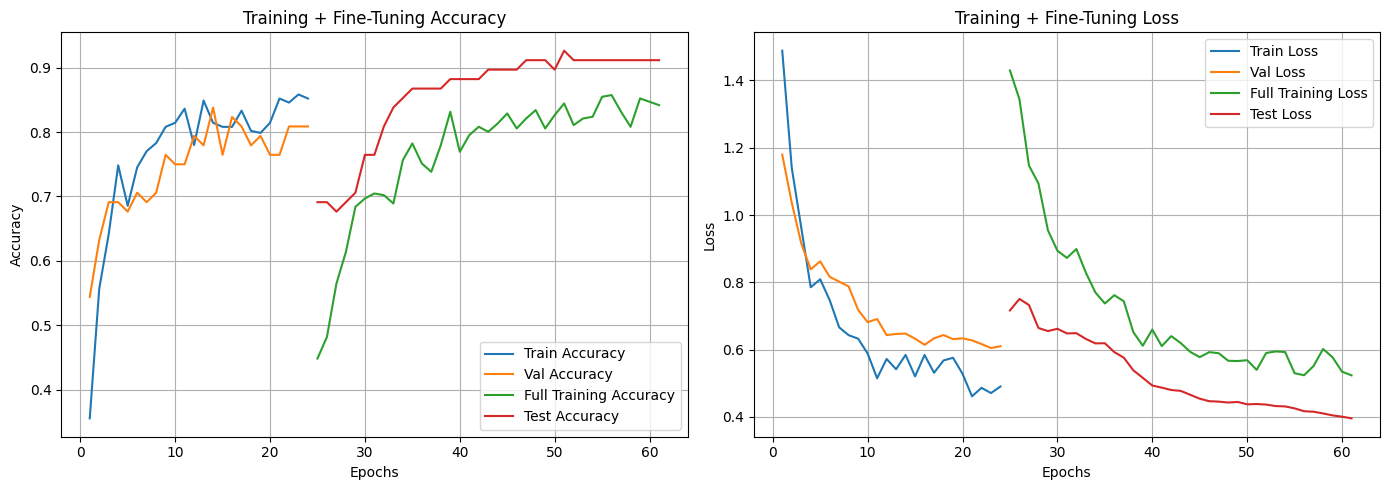

In [50]:
train_acc = history_Xception.history['accuracy']
val_acc = history_Xception.history['val_accuracy']
full_acc = history_Xception_Full.history['accuracy']
test_acc = history_Xception_Full.history['val_accuracy']

train_loss = history_Xception.history['loss']
val_loss = history_Xception.history['val_loss']
full_loss = history_Xception_Full.history['loss']
test_loss = history_Xception_Full.history['val_loss']


epochs_train_val = range(1, len(train_acc)+1)
epochs_full = range(len(train_acc)+1, len(train_acc)+len(full_acc)+1)

plt.figure(figsize=(14,5))


plt.subplot(1,2,1)
plt.plot(epochs_train_val, train_acc, label='Train Accuracy')
plt.plot(epochs_train_val, val_acc, label='Val Accuracy')
plt.plot(epochs_full, full_acc, label='Full Training Accuracy')
plt.plot(epochs_full, test_acc, label='Test Accuracy')
plt.title('Training + Fine-Tuning Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.subplot(1,2,2)
plt.plot(epochs_train_val, train_loss, label='Train Loss')
plt.plot(epochs_train_val, val_loss, label='Val Loss')
plt.plot(epochs_full, full_loss, label='Full Training Loss')
plt.plot(epochs_full, test_loss, label='Test Loss')
plt.title('Training + Fine-Tuning Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# **Xception Confusion Matrix**

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


<Figure size 1000x800 with 0 Axes>

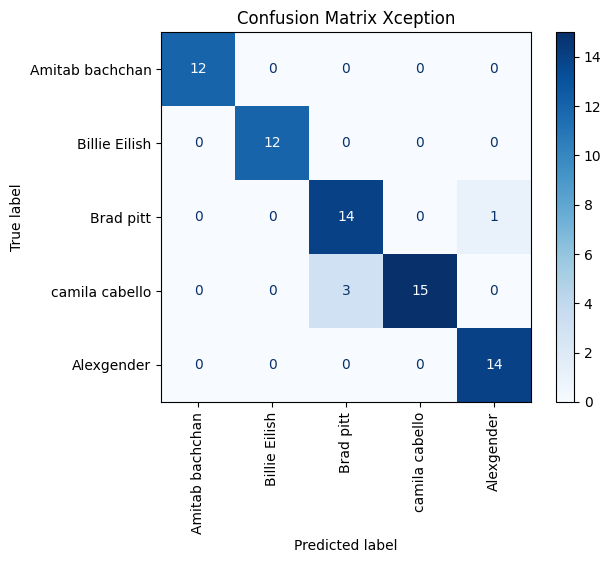

Classification Report:

                 precision    recall  f1-score   support

     Alexgender       1.00      1.00      1.00        12
Amitab bachchan       1.00      1.00      1.00        12
  Billie Eilish       0.82      0.93      0.87        15
      Brad pitt       1.00      0.83      0.91        18
 camila cabello       0.93      1.00      0.97        14

       accuracy                           0.94        71
      macro avg       0.95      0.95      0.95        71
   weighted avg       0.95      0.94      0.94        71



In [51]:
y_pred = model_pretrained_Xception.predict(x_test_images)
predicted_labels = np.argmax(y_pred, axis=1)

predicted_label_names = le.inverse_transform(predicted_labels)
true_label_names = le.inverse_transform(y_test)


cm = confusion_matrix(y_test, predicted_labels)


plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix Xception")
plt.show()


report = classification_report(true_label_names, predicted_label_names, target_names=le.classes_)
print("Classification Report:\n")
print(report)

# **10-OverAll Models Performance**

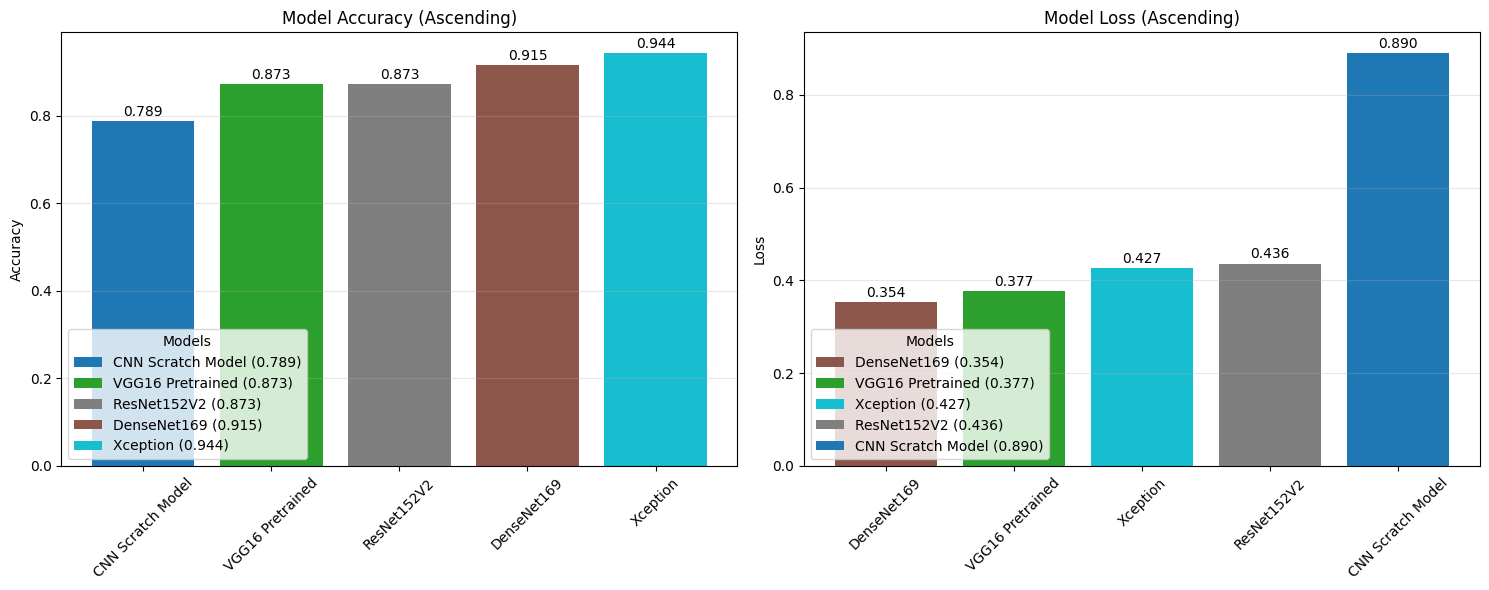

In [52]:
results = {}
results["CNN Scratch Model"] = model.evaluate(x_test_images, y_test, verbose=0)
results["VGG16 Pretrained"] = model_pretrained.evaluate(x_test_images, y_test, verbose=0)
results["DenseNet169"] = model_pretrained_DenseNet169.evaluate(x_test_images, y_test, verbose=0)
results["ResNet152V2"] = model_pretrained_ResNet152V2.evaluate(x_test_images, y_test, verbose=0)
results["Xception"] = model_pretrained_Xception.evaluate(x_test_images, y_test, verbose=0)

model_names = list(results.keys())
losses = [results[m][0] for m in model_names]
accuracies = [results[m][1] for m in model_names]

colors = plt.cm.tab10(np.linspace(0, 1, len(model_names)))

acc_idx = np.argsort(accuracies)
acc_names = [model_names[i] for i in acc_idx]
acc_values = [accuracies[i] for i in acc_idx]
acc_colors = [colors[i] for i in acc_idx]

loss_idx = np.argsort(losses)
loss_names = [model_names[i] for i in loss_idx]
loss_values = [losses[i] for i in loss_idx]
loss_colors = [colors[i] for i in loss_idx]

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
bars = plt.bar(acc_names, acc_values, color=acc_colors)
plt.title("Model Accuracy (Ascending)")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, acc_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.005, f"{val:.3f}", ha='center', va='bottom')
plt.legend(bars, [f"{name} ({val:.3f})" for name, val in zip(acc_names, acc_values)], title="Models" ,  loc="lower left")

plt.subplot(1, 2, 2)
bars2 = plt.bar(loss_names, loss_values, color=loss_colors)
plt.title("Model Loss (Ascending)")
plt.ylabel("Loss")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
for bar, val in zip(bars2, loss_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.005, f"{val:.3f}", ha='center', va='bottom')
plt.legend(bars2, [f"{name} ({val:.3f})" for name, val in zip(loss_names, loss_values)], title="Models" , loc="lower left")

plt.tight_layout()
plt.show()


# **11-Test Models**

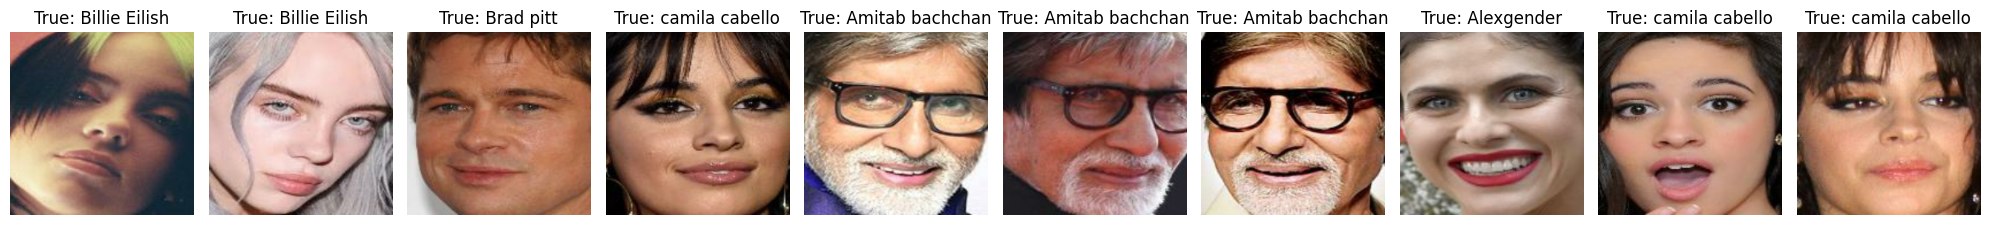


Image 1 (True: Billie Eilish):
  CNN Scratch Model predicts: Billie Eilish ✅
  VGG16 Pretrained predicts: camila cabello ❌
  DenseNet169 predicts: Billie Eilish ✅
  ResNet152V2 predicts: Billie Eilish ✅
  Xception predicts: Billie Eilish ✅

Image 2 (True: Billie Eilish):
  CNN Scratch Model predicts: Billie Eilish ✅
  VGG16 Pretrained predicts: Billie Eilish ✅
  DenseNet169 predicts: Billie Eilish ✅
  ResNet152V2 predicts: Billie Eilish ✅
  Xception predicts: Billie Eilish ✅

Image 3 (True: Brad pitt):
  CNN Scratch Model predicts: Brad pitt ✅
  VGG16 Pretrained predicts: Brad pitt ✅
  DenseNet169 predicts: Brad pitt ✅
  ResNet152V2 predicts: Brad pitt ✅
  Xception predicts: Brad pitt ✅

Image 4 (True: camila cabello):
  CNN Scratch Model predicts: camila cabello ✅
  VGG16 Pretrained predicts: camila cabello ✅
  DenseNet169 predicts: camila cabello ✅
  ResNet152V2 predicts: Billie Eilish ❌
  Xception predicts: camila cabello ✅

Image 5 (True: Amitab bachchan):
  CNN Scratch Model pred

In [53]:
num_images = 10
random_indices = np.random.choice(len(x_test_images), size=num_images, replace=False)

X_input = x_test_images[random_indices]
y_true_labels = le.inverse_transform(y_test[random_indices])

models = {
    "CNN Scratch Model": model,
    "VGG16 Pretrained": model_pretrained,
    "DenseNet169": model_pretrained_DenseNet169,
    "ResNet152V2": model_pretrained_ResNet152V2,
    "Xception": model_pretrained_Xception
}

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
for i in range(len(X_input)):
    plt.subplot(1, num_images, i+1)
    plt.imshow(X_input[i])
    plt.title(f"True: {y_true_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Print predictions with emoji next to predicted class
for i in range(len(X_input)):
    print(f"\nImage {i+1} (True: {y_true_labels[i]}):")
    for name, mdl in models.items():
        y_pred = mdl.predict(X_input[i:i+1], verbose=0)
        pred_label = np.argmax(y_pred, axis=1)
        pred_class = le.inverse_transform(pred_label)[0]
        
        # Emoji ✅ if correct, ❌ if wrong
        emoji = "✅" if pred_class == y_true_labels[i] else "❌"
        print(f"  {name} predicts: {pred_class} {emoji}")


Confusion Matrix for Ensemble Prediction:


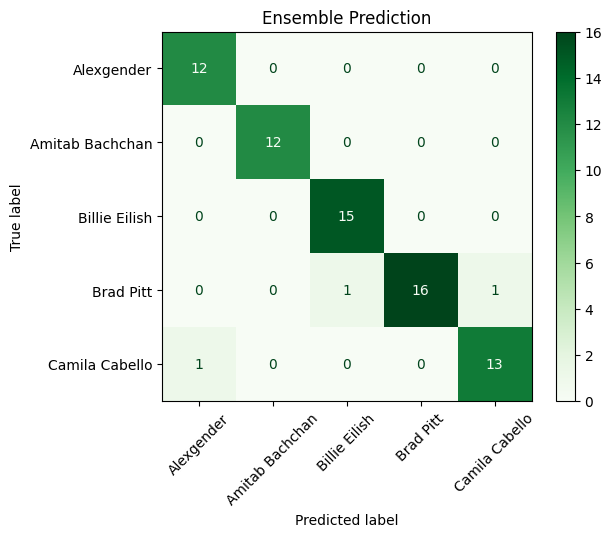

In [54]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ===============================
# Test data
# x_test_images, y_test
class_names = ["Alexgender", "Amitab Bachchan", "Billie Eilish", "Brad Pitt", "Camila Cabello"]
# ===============================

# List of models with the correct variable names
models_dict = {
    "CNN Scratch": model,
    "VGG16": model_pretrained,
    "DenseNet169": model_pretrained_DenseNet169,
    "ResNet152V2": model_pretrained_ResNet152V2,
    "Xception": model_pretrained_Xception
}

# Store predictions and accumulate ensemble probabilities
all_model_preds = {}
ensemble_probs = np.zeros((len(x_test_images), len(class_names)))

# Loop over each model
for name, mdl in models_dict.items():
    preds = mdl.predict(x_test_images, verbose=0)
    all_model_preds[name] = np.argmax(preds, axis=1)
    ensemble_probs += preds  # accumulate probabilities for ensemble

# Convert y_test to label indices if one-hot encoded
if y_test.ndim > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test


# ===============================
# Ensemble Prediction (Sum of Probabilities)
# ===============================
ensemble_pred_labels = np.argmax(ensemble_probs, axis=1)
print("Confusion Matrix for Ensemble Prediction:")
cm_ensemble = confusion_matrix(y_true, ensemble_pred_labels)
disp_ensemble = ConfusionMatrixDisplay(cm_ensemble, display_labels=class_names)
disp_ensemble.plot(cmap=plt.cm.Greens, xticks_rotation=45)
plt.title("Ensemble Prediction")
plt.show()


In [55]:
from sklearn.metrics import classification_report

ensemble_pred_labels = np.argmax(ensemble_probs, axis=1)
print("Classification Report for Ensemble:")
print(classification_report(y_true, ensemble_pred_labels, target_names=class_names))


Classification Report for Ensemble:
                 precision    recall  f1-score   support

     Alexgender       0.92      1.00      0.96        12
Amitab Bachchan       1.00      1.00      1.00        12
  Billie Eilish       0.94      1.00      0.97        15
      Brad Pitt       1.00      0.89      0.94        18
 Camila Cabello       0.93      0.93      0.93        14

       accuracy                           0.96        71
      macro avg       0.96      0.96      0.96        71
   weighted avg       0.96      0.96      0.96        71

